## Graph Learning Data Exploration

We will be looking at the **IMBD-BINARY** and the **MUTAG** graph dataset. Both are graph level classification tasks --> notice that this is a simple task doing binary classification, no graph structure or realtionship need to br predicted, just given a graph (node feature, edge connections, edge features) and its labels (target class), can we predict this class information.

- **MUTAG**
    - Task: Predict if a molecule is mutagenic or not
    - Input: One graph = one molecule (each elements are the nodes, connection between them as edges)
    - Output: One label per graph (0 or 1)

- **IMDB-BINARY**
    - Task: Predict if a movie is Action or Romance genre
    - Input: One graph = one movie (actors as nodes, co-starring as edges)
    - Output: One label per graph (0 or 1)

In [18]:
import torch
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [19]:
imdb = TUDataset(root='./data', name='IMDB-BINARY')
print(f"IMDB-BINARY Dataset:")
print(f"  Number of graphs: {len(imdb)}")
print(f"  Number of classes: {imdb.num_classes}")
print(f"  First graph - Nodes: {imdb[0].num_nodes}, Edges: {imdb[0].num_edges}")

mutag = TUDataset(root='./data', name='MUTAG')
print(f"MUTAG Dataset:")
print(f"  Number of graphs: {len(mutag)}")
print(f"  Number of classes: {mutag.num_classes}")
print(f"  First graph - Nodes: {mutag[0].num_nodes}, Edges: {mutag[0].num_edges}")

IMDB-BINARY Dataset:
  Number of graphs: 1000
  Number of classes: 2
  First graph - Nodes: 20, Edges: 146
MUTAG Dataset:
  Number of graphs: 188
  Number of classes: 2
  First graph - Nodes: 17, Edges: 38


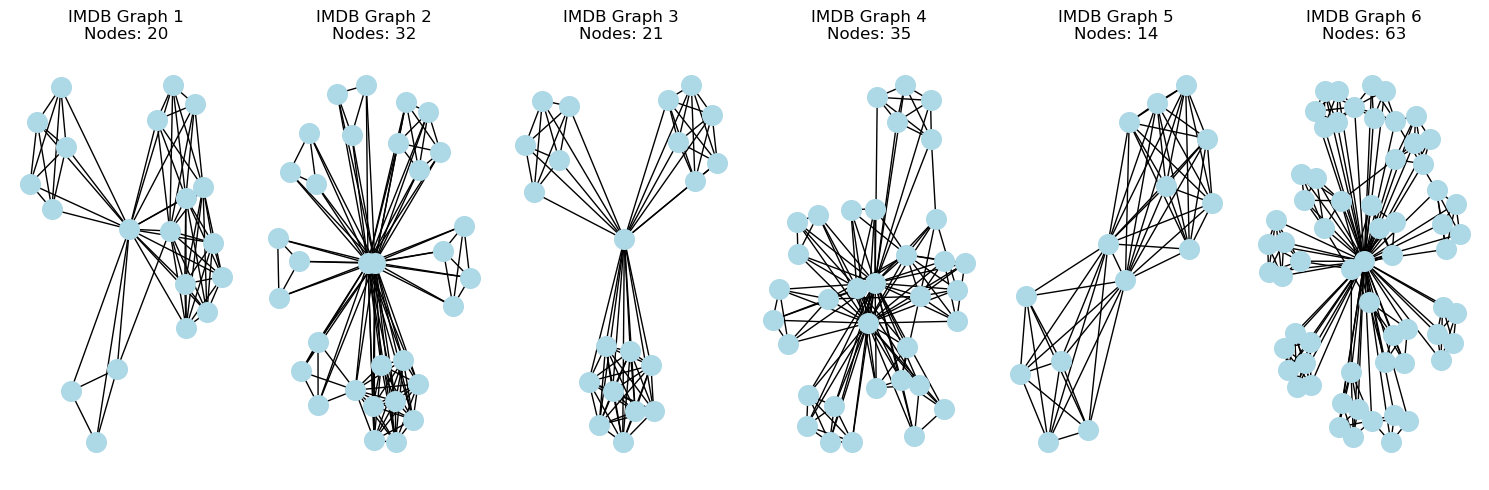

In [20]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    G = to_networkx(imdb[i], to_undirected=True)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='lightblue', node_size=200, 
            with_labels=False, ax=axes[i])
    axes[i].set_title(f'IMDB Graph {i+1}\nNodes: {imdb[i].num_nodes}')
plt.tight_layout()
plt.show()

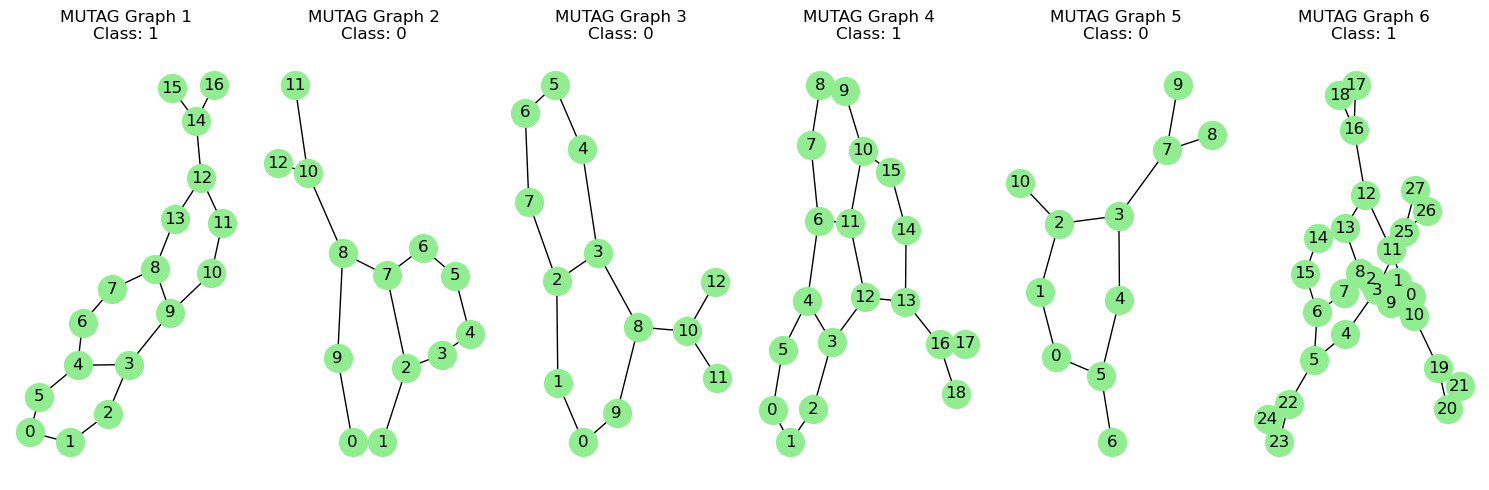

In [21]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))
for i in range(6):
    G = to_networkx(mutag[i], to_undirected=True)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_color='lightgreen', node_size=400, 
            with_labels=True, ax=axes[i])
    axes[i].set_title(f'MUTAG Graph {i+1}\nClass: {mutag[i].y.item()}')
plt.tight_layout()
plt.show()

Export to cytospace only

In [22]:
# data = mutag[0]
# G = to_networkx(data, to_undirected=True)
# atom_types = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']

# for i in range(5):
#     data = mutag[i]
#     G = to_networkx(data, to_undirected=True)
    
#     # Add attributes
#     for node_id, node_features in enumerate(data.x):
#         atom_idx = torch.argmax(node_features).item()
#         G.nodes[node_id]['atom_type'] = atom_types[atom_idx]
#         G.nodes[node_id]['label'] = atom_types[atom_idx]
    
#     # Add graph-level attributes
#     G.graph['class'] = data.y.item()
#     G.graph['mutagenic'] = 'Yes' if data.y.item() == 1 else 'No'
    
#     filename = f"out_graph/mutag_graph_{i}.graphml"
#     nx.write_graphml(G, filename)
#     print(f"✓ Exported {filename}")


IMDB-BINARY - Graph Size Statistics:
  Nodes - Min: 12, Max: 136, Mean: 19.77, Std: 10.06
  Edges - Min: 52, Max: 2498, Mean: 193.06, Std: 211.20

MUTAG - Graph Size Statistics:
  Nodes - Min: 10, Max: 28, Mean: 17.93, Std: 4.58
  Edges - Min: 20, Max: 66, Mean: 39.59, Std: 11.37


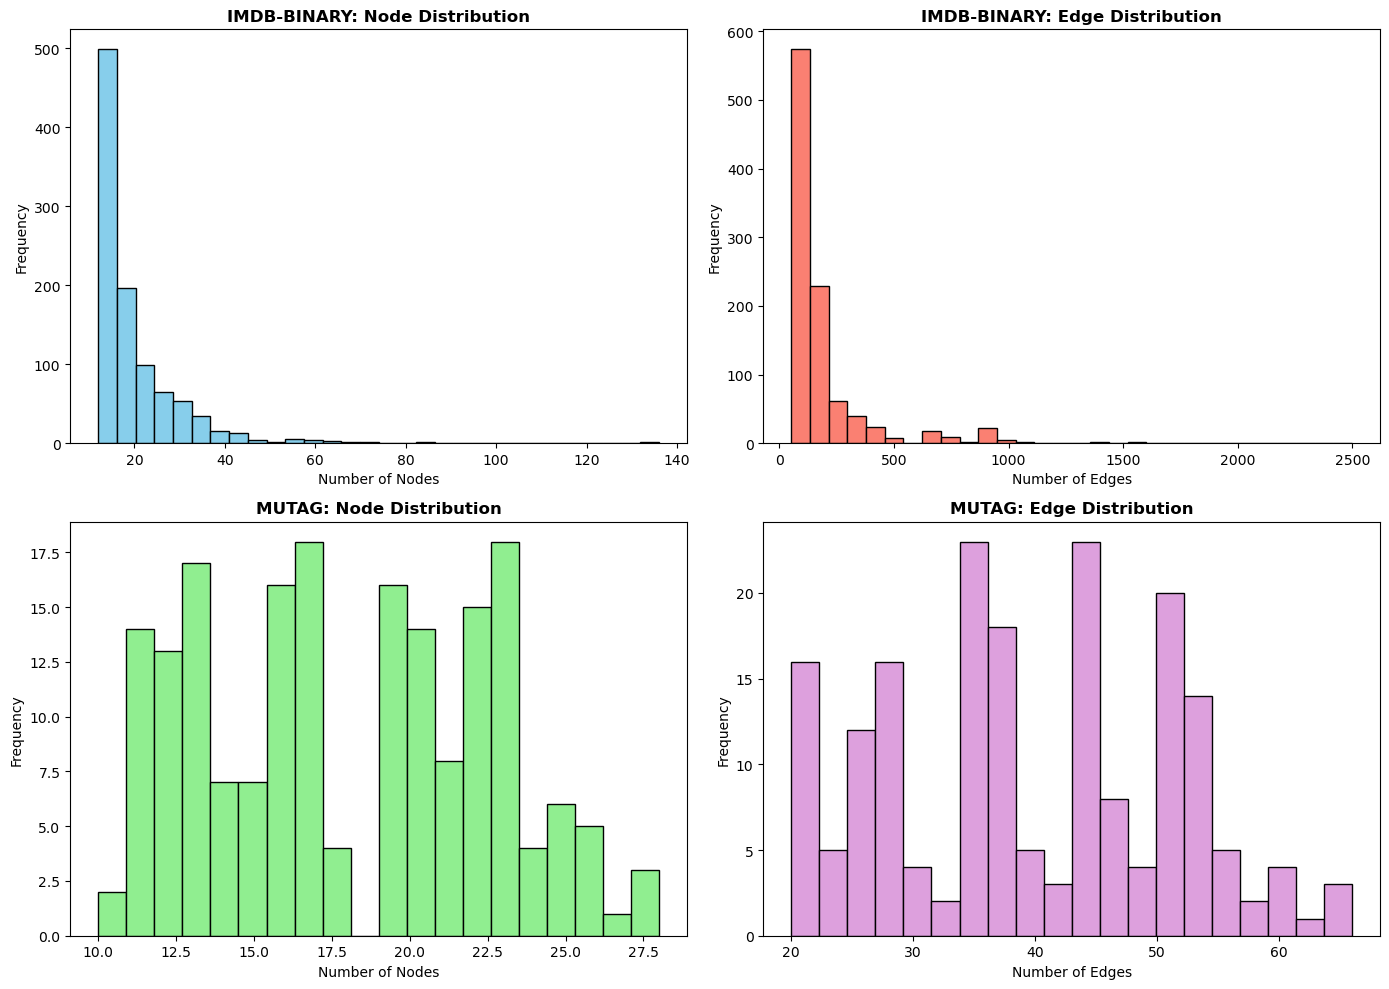

In [23]:
def analyze_graph_sizes(dataset, name):
    num_nodes = [g.num_nodes for g in dataset]
    num_edges = [g.num_edges for g in dataset]
    
    print(f"\n{name} - Graph Size Statistics:")
    print(f"  Nodes - Min: {min(num_nodes)}, Max: {max(num_nodes)}, Mean: {np.mean(num_nodes):.2f}, Std: {np.std(num_nodes):.2f}")
    print(f"  Edges - Min: {min(num_edges)}, Max: {max(num_edges)}, Mean: {np.mean(num_edges):.2f}, Std: {np.std(num_edges):.2f}")
    
    return num_nodes, num_edges

imdb_nodes, imdb_edges = analyze_graph_sizes(imdb, "IMDB-BINARY")
mutag_nodes, mutag_edges = analyze_graph_sizes(mutag, "MUTAG")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(imdb_nodes, bins=30, color='skyblue', edgecolor='black')
axes[0, 0].set_title('IMDB-BINARY: Node Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number of Nodes')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(imdb_edges, bins=30, color='salmon', edgecolor='black')
axes[0, 1].set_title('IMDB-BINARY: Edge Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number of Edges')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(mutag_nodes, bins=20, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('MUTAG: Node Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number of Nodes')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(mutag_edges, bins=20, color='plum', edgecolor='black')
axes[1, 1].set_title('MUTAG: Edge Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Edges')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


IMDB-BINARY - Degree Statistics:
  Average Degree: 9.76
  Min Degree: 1
  Max Degree: 135
  Std Degree: 7.43

MUTAG - Degree Statistics:
  Average Degree: 2.21
  Min Degree: 1
  Max Degree: 4
  Std Degree: 0.74


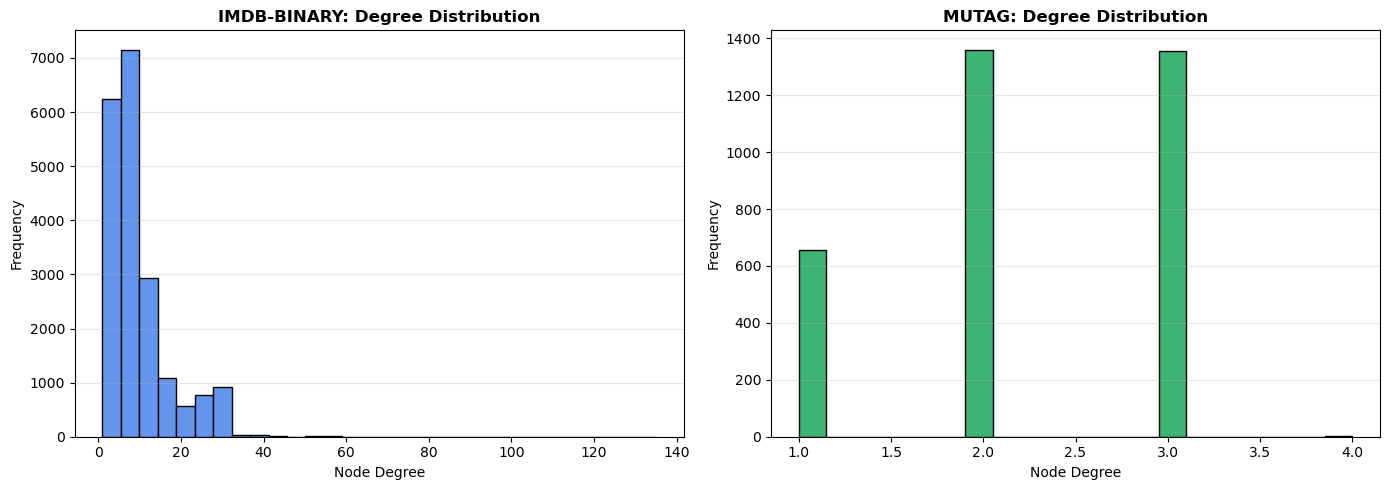

In [24]:
def analyze_degree_statistics(dataset, name):
    all_degrees = []
    for data in dataset:
        G = to_networkx(data, to_undirected=True)
        degrees = [deg for node, deg in G.degree()]
        all_degrees.extend(degrees)
    
    print(f"\n{name} - Degree Statistics:")
    print(f"  Average Degree: {np.mean(all_degrees):.2f}")
    print(f"  Min Degree: {min(all_degrees)}")
    print(f"  Max Degree: {max(all_degrees)}")
    print(f"  Std Degree: {np.std(all_degrees):.2f}")
    
    return all_degrees

imdb_degrees = analyze_degree_statistics(imdb, "IMDB-BINARY")
mutag_degrees = analyze_degree_statistics(mutag, "MUTAG")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(imdb_degrees, bins=30, color='cornflowerblue', edgecolor='black')
axes[0].set_title('IMDB-BINARY: Degree Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Node Degree')
axes[0].set_ylabel('Frequency')
axes[0].grid(axis='y', alpha=0.3)

axes[1].hist(mutag_degrees, bins=20, color='mediumseagreen', edgecolor='black')
axes[1].set_title('MUTAG: Degree Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Node Degree')
axes[1].set_ylabel('Frequency')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


   Atom types in MUTAG: ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
   (Features are one-hot encoded)


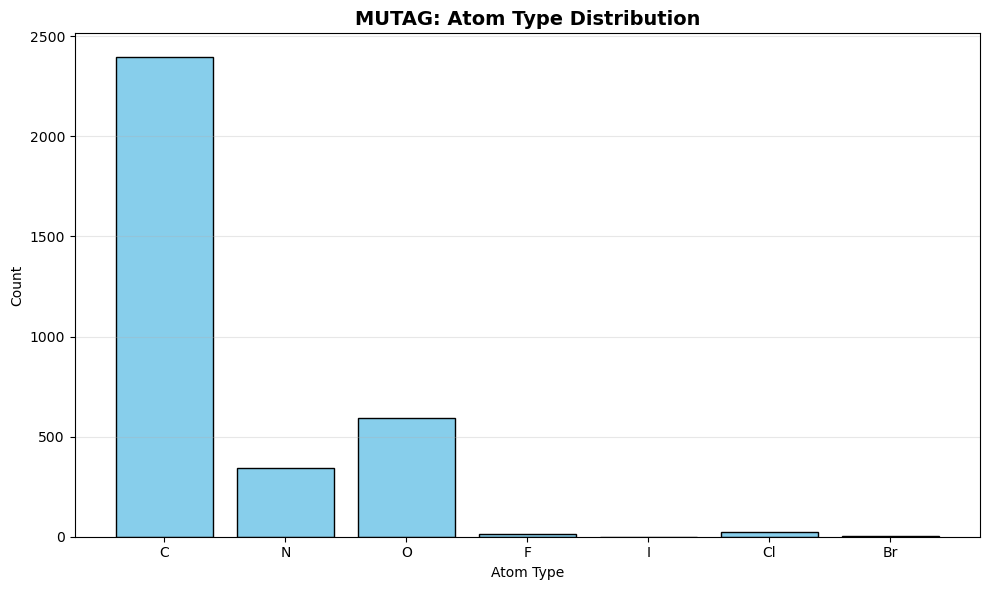

In [25]:
atom_types = ['C', 'N', 'O', 'F', 'I', 'Cl', 'Br']
print(f"\n   Atom types in MUTAG: {atom_types}")
print(f"   (Features are one-hot encoded)")

atom_counts = {atom: 0 for atom in atom_types}

for data in mutag:
    for node_features in data.x:
        atom_idx = torch.argmax(node_features).item()
        if atom_idx < len(atom_types):
            atom_counts[atom_types[atom_idx]] += 1

plt.figure(figsize=(10, 6))
plt.bar(atom_counts.keys(), atom_counts.values(), color='skyblue', edgecolor='black')
plt.title('MUTAG: Atom Type Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Atom Type')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
node_feature_stats = []
for i, data in enumerate(mutag[:10]):  # First 10 graphs
    feature_sum = data.x.sum(dim=0)
    atom_composition = [atom_types[j] for j in range(len(atom_types)) if feature_sum[j] > 0]
    node_feature_stats.append({
        'Graph': i,
        'Num Nodes': data.num_nodes,
        'Label': data.y.item(),
        'Atoms Present': ', '.join(atom_composition)
    })

df_features = pd.DataFrame(node_feature_stats)
print("\n" + df_features.to_string(index=False))


 Graph  Num Nodes  Label Atoms Present
     0         17      1       C, N, O
     1         13      0       C, N, O
     2         13      0       C, N, O
     3         19      1       C, N, O
     4         11      0    C, N, O, F
     5         28      1       C, N, O
     6         16      0       C, N, O
     7         20      1       C, N, O
     8         12      0       C, N, O
     9         17      1       C, N, O


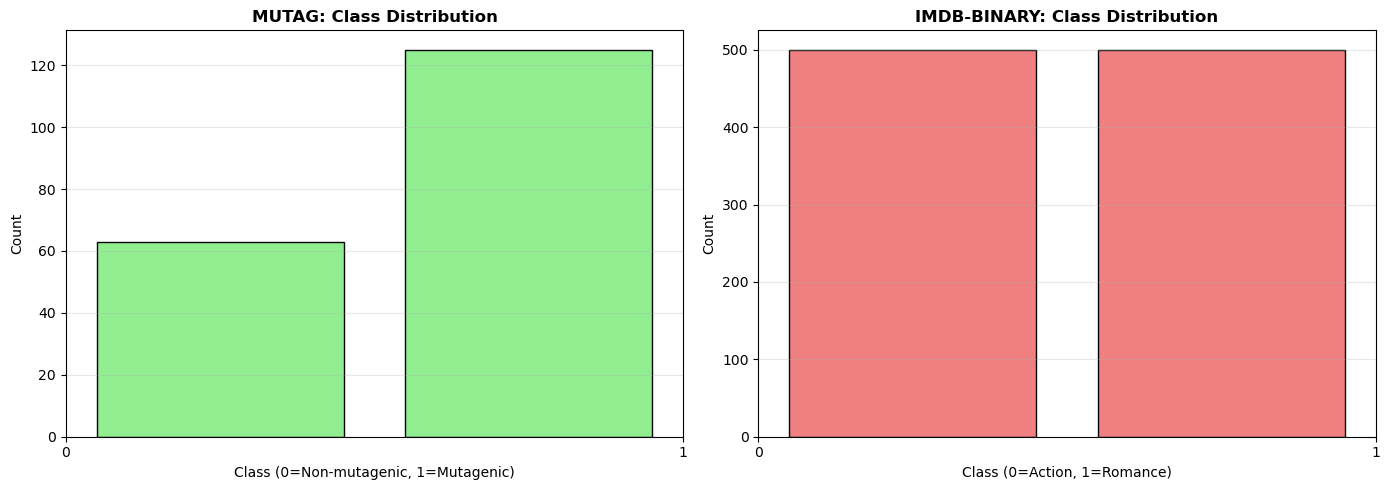

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

mutag_labels = [data.y.item() for data in mutag]
axes[0].hist(mutag_labels, bins=2, color='lightgreen', edgecolor='black', rwidth=0.8)
axes[0].set_title('MUTAG: Class Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Class (0=Non-mutagenic, 1=Mutagenic)')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].grid(axis='y', alpha=0.3)

imdb_labels = [data.y.item() for data in imdb]
axes[1].hist(imdb_labels, bins=2, color='lightcoral', edgecolor='black', rwidth=0.8)
axes[1].set_title('IMDB-BINARY: Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Class (0=Action, 1=Romance)')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Naive Modeling Tasks

In [28]:
torch.manual_seed(42)
np.random.seed(42)

dataset = TUDataset(root='./data', name='MUTAG')
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = [dataset[i] for i in train_idx]
test_dataset = [dataset[i] for i in test_idx]

print(f"\nDataset Split:")
print(f"Training graphs: {len(train_dataset)}")
print(f"Test graphs: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(SimpleGNN, self).__init__()
        
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        # global pooling (aggregate node features to graph-level)
        x = global_mean_pool(x, batch)
        
        x = self.fc(x)
        
        return x

model = SimpleGNN(
    num_features=dataset.num_features,
    hidden_dim=128,
    num_classes=dataset.num_classes
)

print("\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.y.size(0)
    
    return total_loss / len(train_loader), correct / total

def test(loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    
    return correct / total


Dataset Split:
Training graphs: 150
Test graphs: 38

Model Architecture:
SimpleGNN(
  (conv1): GCNConv(7, 128)
  (conv2): GCNConv(128, 128)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

Total parameters: 17794


In [29]:
epochs = 500
train_losses = []
train_accs = []
test_accs = []

print("Training started...\n")

for epoch in tqdm(range(1, epochs + 1), desc="Training Progress"):
    loss, train_acc = train()
    test_acc = test(test_loader)
    
    train_losses.append(loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    # if epoch % 10 == 0:
    #     tqdm.write(f'Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}')

print("\nTraining complete!")

Training started...



Training Progress: 100%|██████████| 500/500 [01:43<00:00,  4.83it/s]


Training complete!


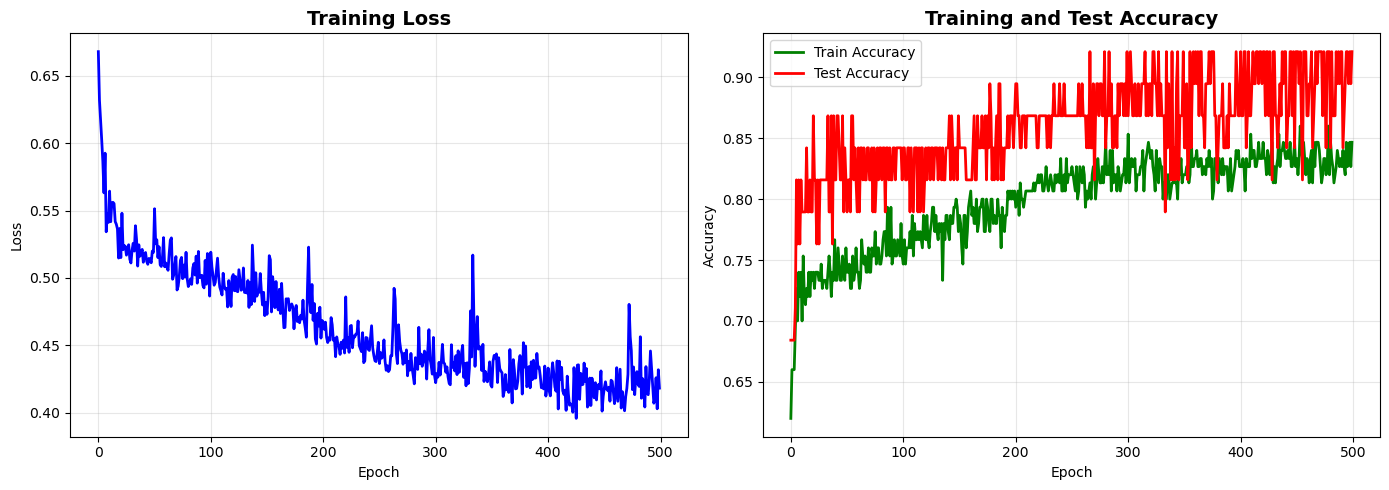

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(train_losses, color='blue', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(alpha=0.3)

axes[1].plot(train_accs, label='Train Accuracy', color='green', linewidth=2)
axes[1].plot(test_accs, label='Test Accuracy', color='red', linewidth=2)
axes[1].set_title('Training and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
final_train_acc = test(train_loader)
final_test_acc = test(test_loader)

print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Test Accuracy: {final_test_acc:.4f} ({final_test_acc*100:.2f}%)")
print("="*50)

model.eval()
print("\n" + "="*50)
print("PREDICTIONS ON TEST EXAMPLES")
print("="*50)

with torch.no_grad():
    for i in range(5):
        data = test_dataset[i]
        data_batch = next(iter(DataLoader([data], batch_size=1)))
        out = model(data_batch)
        pred = out.argmax(dim=1).item()
        true_label = data.y.item()
        
        print(f"\nGraph {i}:")
        print(f"  Nodes: {data.num_nodes}, Edges: {data.num_edges}")
        print(f"  True Label: {true_label} ({'Mutagenic' if true_label == 1 else 'Non-mutagenic'})")
        print(f"  Predicted: {pred} ({'Mutagenic' if pred == 1 else 'Non-mutagenic'})")
        print(f"  Correct: {'✓' if pred == true_label else '✗'}")


FINAL RESULTS
Final Training Accuracy: 0.8333 (83.33%)
Final Test Accuracy: 0.9211 (92.11%)

PREDICTIONS ON TEST EXAMPLES

Graph 0:
  Nodes: 22, Edges: 50
  True Label: 1 (Mutagenic)
  Predicted: 1 (Mutagenic)
  Correct: ✓

Graph 1:
  Nodes: 22, Edges: 50
  True Label: 1 (Mutagenic)
  Predicted: 1 (Mutagenic)
  Correct: ✓

Graph 2:
  Nodes: 13, Edges: 28
  True Label: 0 (Non-mutagenic)
  Predicted: 0 (Non-mutagenic)
  Correct: ✓

Graph 3:
  Nodes: 22, Edges: 50
  True Label: 1 (Mutagenic)
  Predicted: 1 (Mutagenic)
  Correct: ✓

Graph 4:
  Nodes: 23, Edges: 54
  True Label: 1 (Mutagenic)
  Predicted: 1 (Mutagenic)
  Correct: ✓


---

# Graph Learning for Multi-Class Node Classification

We will be using **Cora**, a citation network dataset, to serve as an example:
- Nodes: scientific publications (papers)
- Edges: citation links between papers (if paper A cites paper B, there's an edge)
- Node Features: 1,433-dimensional bag-of-words feature vectors (word presence/absence in each paper)

In [39]:
torch.manual_seed(42)
np.random.seed(42)

print("Loading Cora dataset...")
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")

Loading Cora dataset...
Dataset: Cora()
Number of graphs: 1
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [49]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        
        return x

model = GCN(
    num_features=dataset.num_features,
    hidden_channels=16,
    num_classes=dataset.num_classes
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        
        train_correct = pred[data.train_mask] == data.y[data.train_mask]
        train_acc = int(train_correct.sum()) / int(data.train_mask.sum())
        
        val_correct = pred[data.val_mask] == data.y[data.val_mask]
        val_acc = int(val_correct.sum()) / int(data.val_mask.sum())
        
        test_correct = pred[data.test_mask] == data.y[data.test_mask]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
        
    return train_acc, val_acc, test_acc, pred

In [50]:
print("\nTraining GCN model...")
train_losses = []
val_accuracies = []

for epoch in tqdm(range(1, 501), desc="Training", unit="epoch"):
    loss = train()
    train_acc, val_acc, test_acc, _ = test()
    train_losses.append(loss)
    val_accuracies.append(val_acc)
    
    # if epoch % 20 == 0:
    #     tqdm.write(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, '
    #                f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

train_acc, val_acc, test_acc, predictions = test()
print(f"\n{'='*60}")
print(f"Final Results:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"{'='*60}")


Training GCN model...


Training: 100%|██████████| 500/500 [00:18<00:00, 27.52epoch/s]


Final Results:
Train Accuracy: 1.0000
Validation Accuracy: 0.7660
Test Accuracy: 0.8060


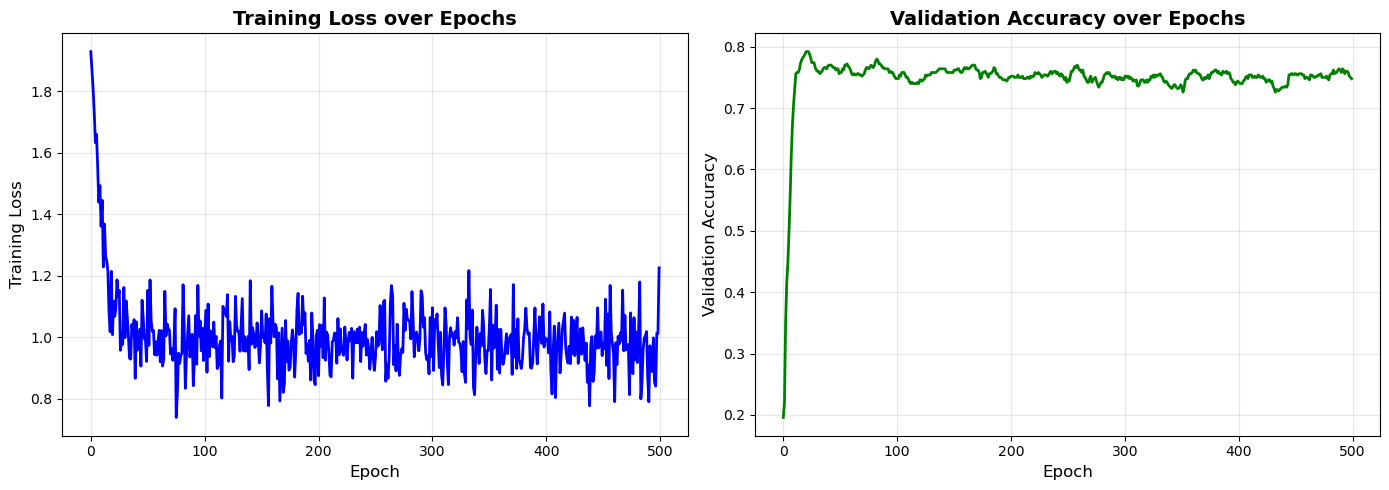

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, color='blue', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(val_accuracies, color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontsize=12)
ax2.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Computing Kamada-Kawai layout...


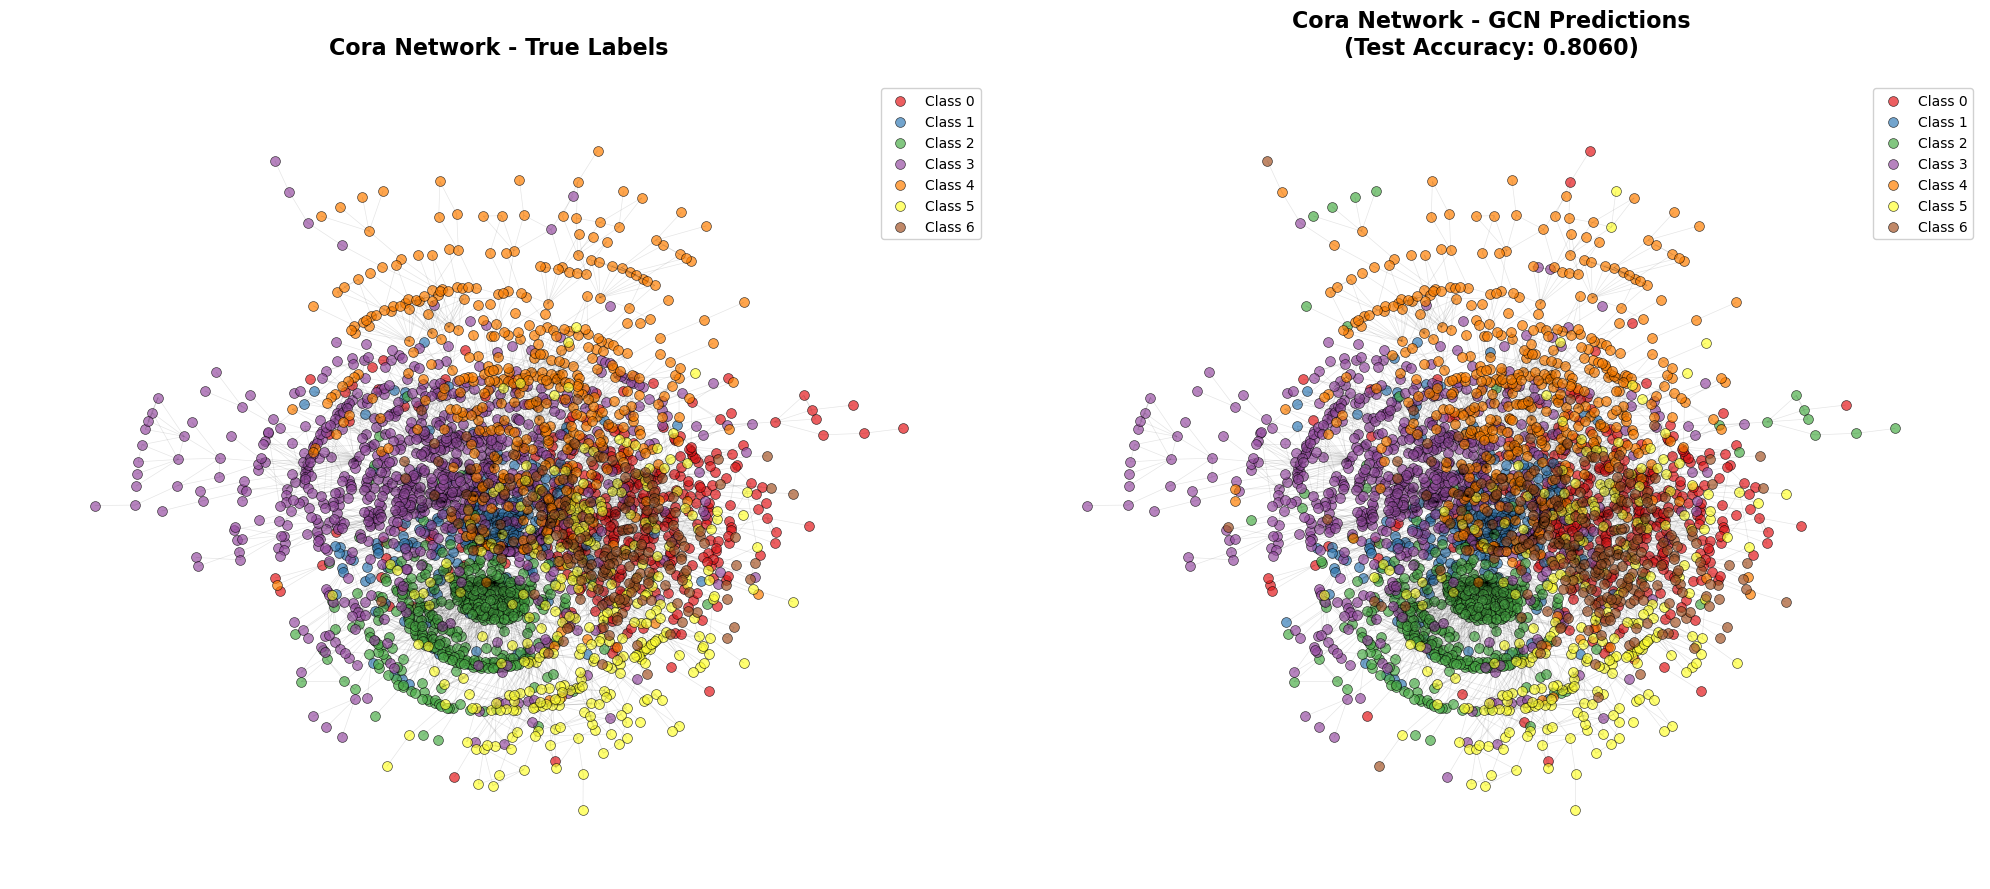

In [52]:
G = nx.Graph()
edge_index = data.edge_index.numpy()
G.add_edges_from(zip(edge_index[0], edge_index[1]))

print("Computing Kamada-Kawai layout...")
pos = nx.kamada_kawai_layout(G)

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

ax = axes[0]
for class_id in range(dataset.num_classes):
    mask = (data.y.numpy() == class_id)
    nodes = np.where(mask)[0]
    node_positions = np.array([pos[n] for n in nodes])
    ax.scatter(node_positions[:, 0], node_positions[:, 1], 
              c=colors[class_id], label=f'Class {class_id}',
              s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.1, width=0.5)

ax.set_title('Cora Network - True Labels', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.axis('off')

ax = axes[1]
predictions_np = predictions.numpy()
for class_id in range(dataset.num_classes):
    mask = (predictions_np == class_id)
    nodes = np.where(mask)[0]
    node_positions = np.array([pos[n] for n in nodes])
    ax.scatter(node_positions[:, 0], node_positions[:, 1], 
              c=colors[class_id], label=f'Class {class_id}',
              s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.1, width=0.5)

ax.set_title(f'Cora Network - GCN Predictions\n(Test Accuracy: {test_acc:.4f})', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.axis('off')

plt.tight_layout()
plt.show()

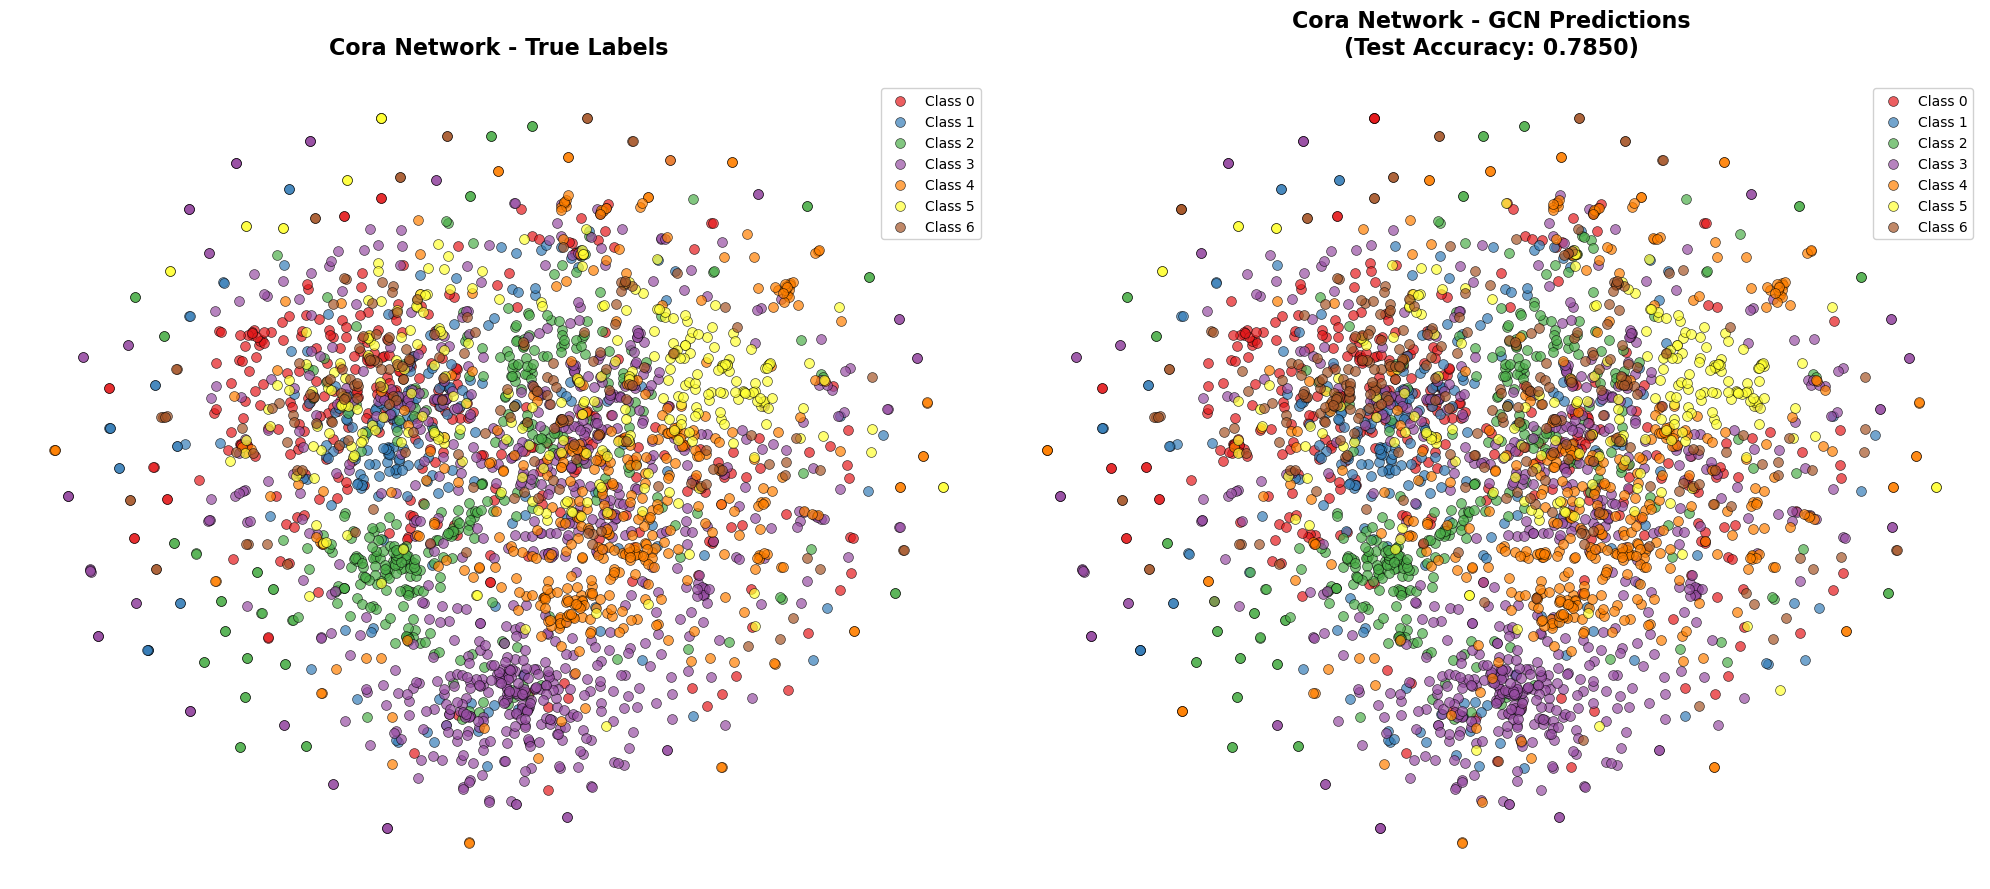

In [48]:
G = nx.Graph()
edge_index = data.edge_index.numpy()
G.add_edges_from(zip(edge_index[0], edge_index[1]))

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
node_embeddings = data.x.numpy()
pos_array = tsne.fit_transform(node_embeddings)
pos = {i: pos_array[i] for i in range(len(pos_array))}

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
ax = axes[0]
for class_id in range(dataset.num_classes):
    mask = (data.y.numpy() == class_id)
    nodes = np.where(mask)[0]
    node_positions = np.array([pos[n] for n in nodes])
    ax.scatter(node_positions[:, 0], node_positions[:, 1], 
              c=colors[class_id], label=f'Class {class_id}',
              s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_title('Cora Network - True Labels', fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.axis('off')

ax = axes[1]
predictions_np = predictions.numpy()
for class_id in range(dataset.num_classes):
    mask = (predictions_np == class_id)
    nodes = np.where(mask)[0]
    node_positions = np.array([pos[n] for n in nodes])
    ax.scatter(node_positions[:, 0], node_positions[:, 1], 
              c=colors[class_id], label=f'Class {class_id}',
              s=50, alpha=0.7, edgecolors='black', linewidth=0.5)

ax.set_title(f'Cora Network - GCN Predictions\n(Test Accuracy: {test_acc:.4f})', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.axis('off')

plt.tight_layout()
plt.show()

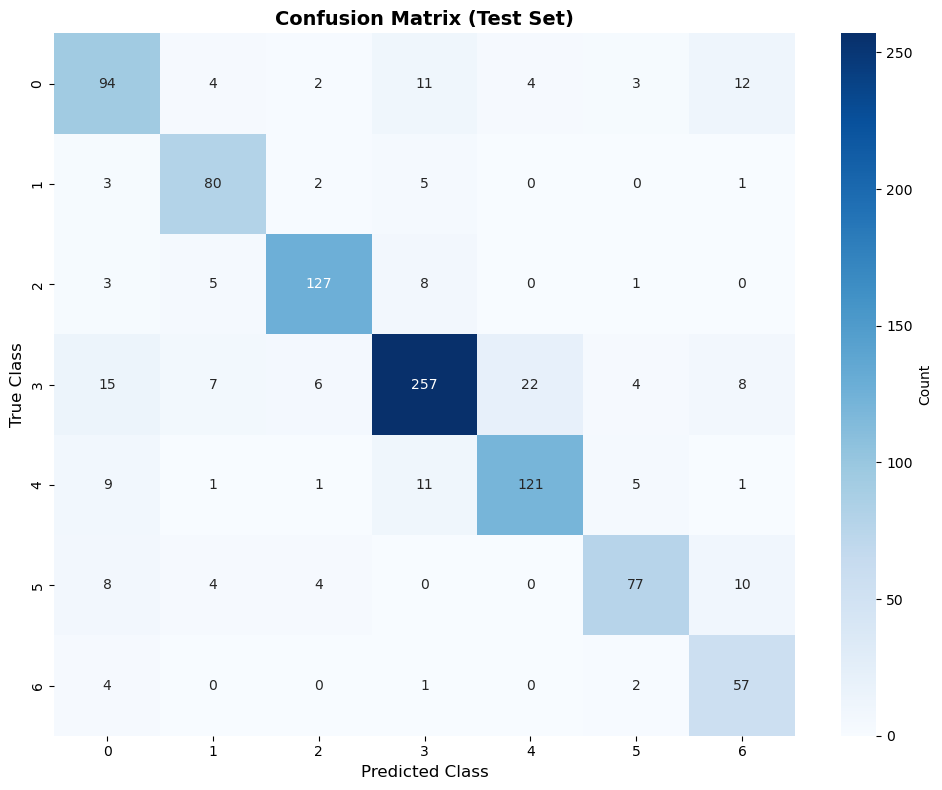

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_true = data.y[data.test_mask].numpy()
test_pred = predictions[data.test_mask].numpy()

cm = confusion_matrix(test_true, test_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(dataset.num_classes),
            yticklabels=range(dataset.num_classes),
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---